# Лабораторная работа №2. Проведение исследований с логистической и линейной регрессией

Импорт библиотек и настройки окружения\
Подключаем библиотеки, настраиваем стиль визуализации и фиксируем random_state

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

pd.set_option("display.max_columns", 120)
RANDOM_STATE = 42
sns.set_theme(style="whitegrid")


Загрузка датасетов\
Берем те же реальные задачи: COVID (классификация) и страховые выплаты (регрессия)

In [2]:
covid_path = Path("../datasets/covid.csv")
insurance_path = Path("../datasets/insurance.csv")

df_covid_raw = pd.read_csv(covid_path)
df_insurance_raw = pd.read_csv(insurance_path)

Вспомогательные функции для метрик, таблиц и графиков\
Унификация метрик, вывод таблиц результатов и вспомогательные построения

In [3]:
def classification_report_dict(y_true, y_pred, y_proba=None):
    scores = {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }
    if y_proba is not None:
        try:
            scores["roc_auc"] = roc_auc_score(y_true, y_proba)
        except ValueError:
            scores["roc_auc"] = np.nan
    return scores


def regression_report_dict(y_true, y_pred):
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_true, y_pred)),
        "r2": r2_score(y_true, y_pred),
    }


def show_results_table(results, title):
    print(f"\n{title}")
    display_df = pd.DataFrame(results).T
    display_df = display_df.round(4)
    print(display_df)


def plot_confusion(cm, title):
    plt.figure(figsize=(4.5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_roc_pr(y_true, proba_dict):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    for label, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        plt.plot(fpr, tpr, label=f"{label}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC-кривые")
    plt.legend()

    plt.subplot(1, 2, 2)
    for label, proba in proba_dict.items():
        precision, recall, _ = precision_recall_curve(y_true, proba)
        plt.plot(recall, precision, label=f"{label}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_residuals(true, preds_dict):
    plt.figure(figsize=(8, 4))
    for label, pred in preds_dict.items():
        residuals = true - pred
        sns.kdeplot(residuals, label=label, fill=True, alpha=0.3)
    plt.title("Плотности остатков моделей")
    plt.xlabel("Ошибка (true - pred)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_predictions(true, preds_dict):
    plt.figure(figsize=(12, 5))
    for i, (label, pred) in enumerate(preds_dict.items()):
        plt.subplot(1, len(preds_dict), i + 1)
        sns.scatterplot(x=true, y=pred, alpha=0.6)
        m, M = true.min(), true.max()
        plt.plot([m, M], [m, M], "r--")
        plt.title(f"{label}: true vs pred")
        plt.xlabel("true")
        plt.ylabel("pred")
    plt.tight_layout()
    plt.show()


Предобработка COVID под логистическую регрессию\
Целевая переменная: факт смерти, заменяем коды пропусков на NaN, оставляем признаки

In [4]:
covid_df = df_covid_raw.copy()
covid_df["died"] = (covid_df["DATE_DIED"] != "9999-99-99").astype(int)
covid_df["COVID_POSITIVE"] = (covid_df["CLASIFFICATION_FINAL"] <= 3).astype(int)
covid_df = covid_df.drop(columns=["DATE_DIED"])

covid_df = covid_df.replace({97: np.nan, 98: np.nan, 99: np.nan})
feature_cols_covid = [c for c in covid_df.columns if c != "died"]

covid_sample = covid_df.sample(n=80000, random_state=RANDOM_STATE)


COVID EDA: распределения и риски\
Быстрый обзор таргета, возраста и влияния коморбидностей

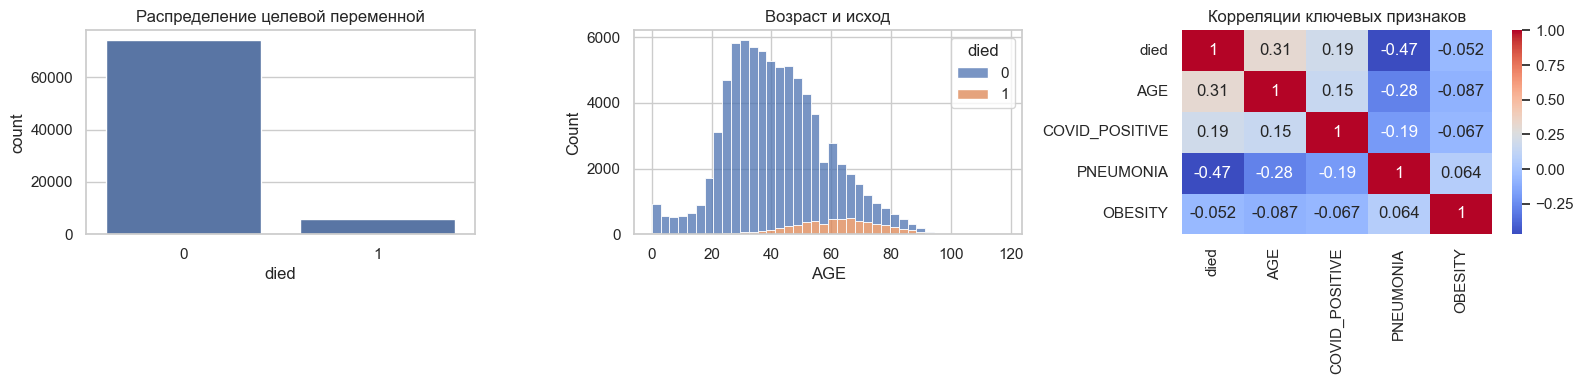

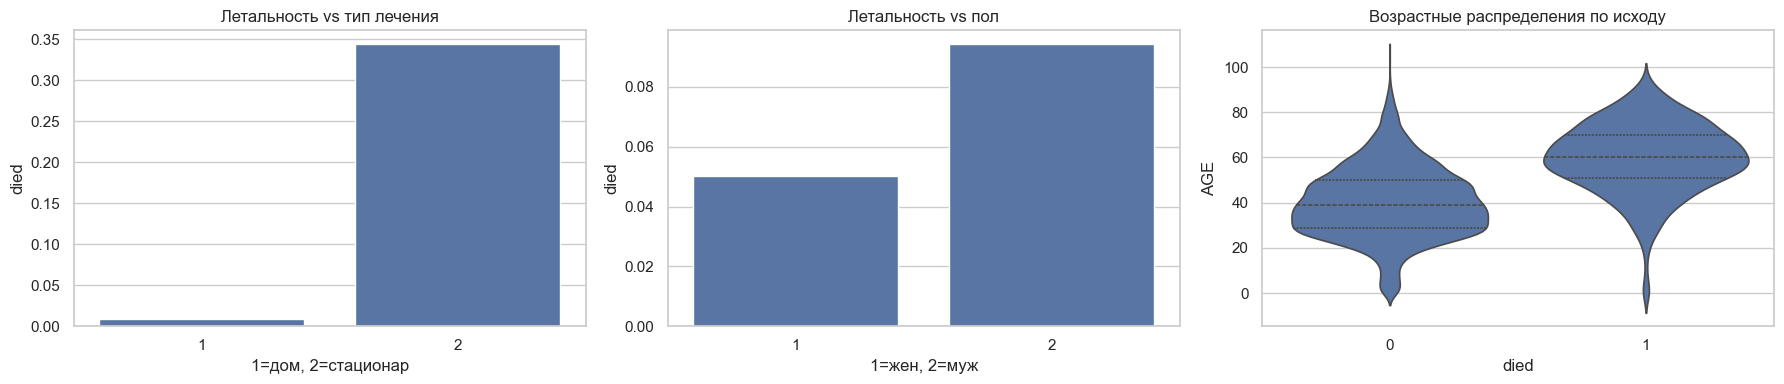

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
sns.countplot(data=covid_sample, x="died", ax=axes[0])
axes[0].set_title("Распределение целевой переменной")

sns.histplot(
    data=covid_sample,
    x="AGE",
    hue="died",
    multiple="stack",
    bins=40,
    ax=axes[1],
)
axes[1].set_title("Возраст и исход")

corr_subset = covid_sample[["died", "AGE", "COVID_POSITIVE", "PNEUMONIA", "OBESITY"]]
sns.heatmap(corr_subset.corr(), annot=True, cmap="coolwarm", ax=axes[2])
axes[2].set_title("Корреляции ключевых признаков")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.barplot(
    data=covid_sample,
    x="PATIENT_TYPE",
    y="died",
    estimator=np.mean,
    errorbar=None,
    ax=axes[0],
)
axes[0].set_title("Летальность vs тип лечения")
axes[0].set_xlabel("1=дом, 2=стационар")

sns.barplot(
    data=covid_sample,
    x="SEX",
    y="died",
    estimator=np.mean,
    errorbar=None,
    ax=axes[1],
)
axes[1].set_title("Летальность vs пол")
axes[1].set_xlabel("1=жен, 2=муж")

sns.violinplot(
    data=covid_sample.sample(8000, random_state=RANDOM_STATE),
    x="died",
    y="AGE",
    inner="quart",
    ax=axes[2],
)
axes[2].set_title("Возрастные распределения по исходу")
plt.tight_layout()
plt.show()


Бейзлайн логистической регрессии (sklearn)\
Пайплайн: импутация, стандартизация, LogisticRegression c классическим l2

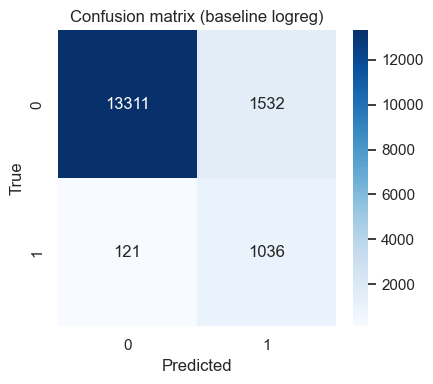

In [6]:
X_covid = covid_sample[feature_cols_covid]
y_covid = covid_sample["died"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_covid, y_covid, test_size=0.2, stratify=y_covid, random_state=RANDOM_STATE
)

log_reg_baseline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        (
            "model",
            LogisticRegression(
                penalty="l2",
                C=1.0,
                max_iter=1500,
                solver="saga",
                class_weight="balanced",
                n_jobs=-1,
            ),
        ),
    ]
)

log_reg_baseline.fit(X_train_c, y_train_c)
base_pred = log_reg_baseline.predict(X_test_c)
base_proba = log_reg_baseline.predict_proba(X_test_c)[:, 1]

results_cls = {}
results_cls["baseline_logreg"] = classification_report_dict(y_test_c, base_pred, base_proba)

cm_base = confusion_matrix(y_test_c, base_pred)
plot_confusion(cm_base, "Confusion matrix (baseline logreg)")

Тюнинг логистической регрессии\
GridSearchCV по штрафу и силе регуляризации

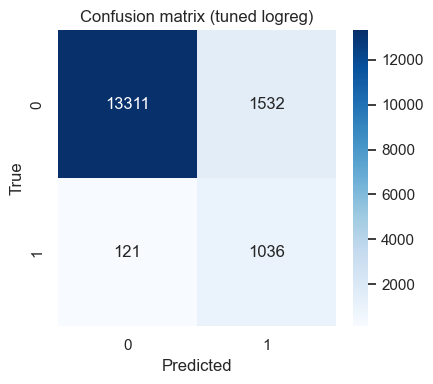

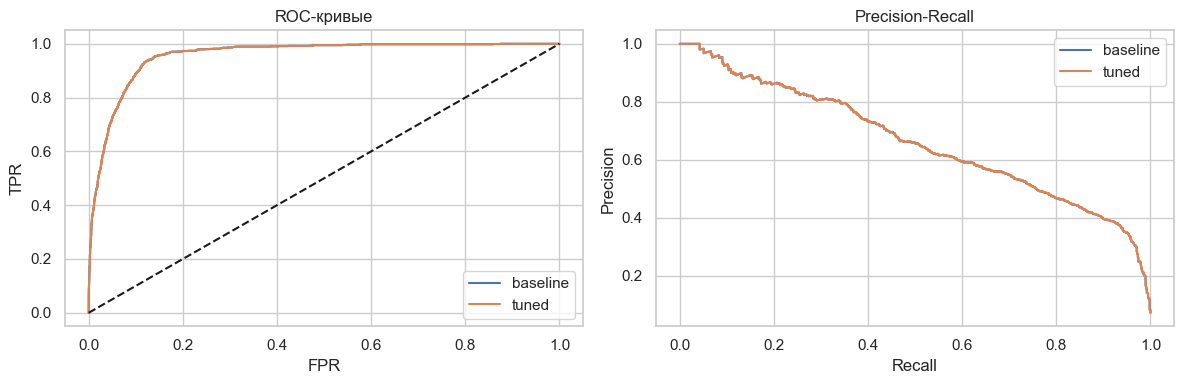

In [7]:
param_grid_log = {
    "model__penalty": ["l2", "l1"],
    "model__C": [0.1, 1.0, 5.0],
}

cv_cls = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)

log_reg_search = GridSearchCV(
    estimator=log_reg_baseline,
    param_grid=param_grid_log,
    scoring="f1",
    cv=cv_cls,
    n_jobs=-1,
)
log_reg_search.fit(X_train_c, y_train_c)

best_log_reg = log_reg_search.best_estimator_
best_pred = best_log_reg.predict(X_test_c)
best_proba = best_log_reg.predict_proba(X_test_c)[:, 1]

results_cls["tuned_logreg"] = classification_report_dict(y_test_c, best_pred, best_proba)

cm_best = confusion_matrix(y_test_c, best_pred)
plot_confusion(cm_best, "Confusion matrix (tuned logreg)")

plot_roc_pr(y_test_c, {"baseline": base_proba, "tuned": best_proba})


Ручная имплементация логистической регрессии (градиентный спуск)\
Простая бинарная логистика с l2-регуляризацией

In [8]:
class CustomLogisticRegression:
    def __init__(self, lr=0.1, n_iter=800, l2=0.0):
        self.lr = lr
        self.n_iter = n_iter
        self.l2 = l2

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0.0
        for _ in range(self.n_iter):
            linear = np.dot(X, self.w) + self.b
            pred = self._sigmoid(linear)
            error = pred - y
            grad_w = (1 / n_samples) * np.dot(X.T, error) + self.l2 * self.w
            grad_b = error.mean()
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b
        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=float)
        scores = self._sigmoid(np.dot(X, self.w) + self.b)
        return np.vstack([1 - scores, scores]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)


Оценка кастомной логистики на компактной выборке\
Уменьшаем размер для скорости, оставляем тот же препроцессинг

/Users/hedgefo9/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/hedgefo9/Library/Python/3.9/lib/python/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


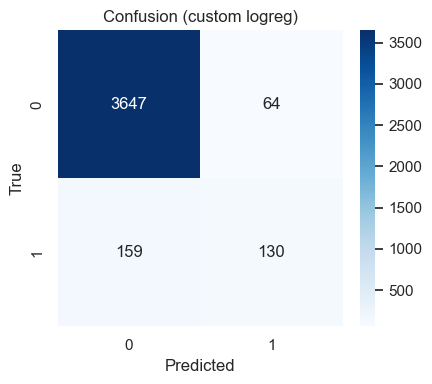

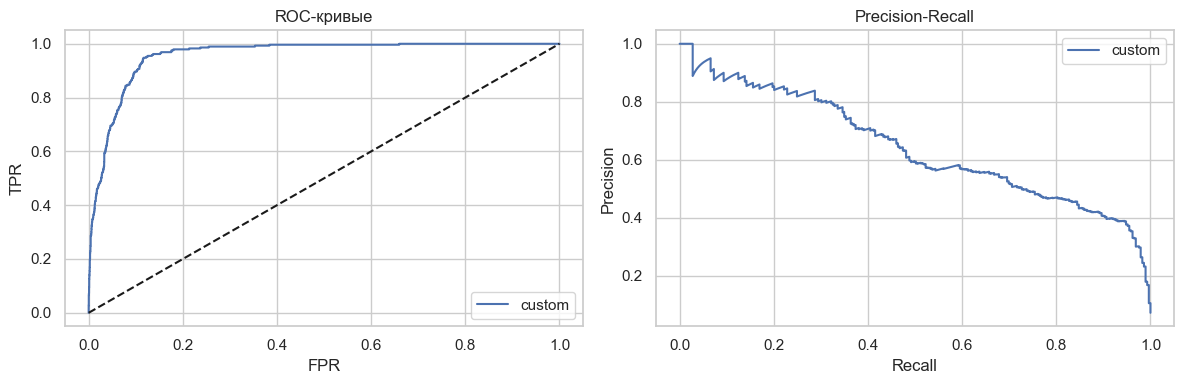


Метрики классификации (логистическая регрессия)
                 accuracy  precision  recall      f1  roc_auc
baseline_logreg    0.8967     0.4034  0.8954  0.5562   0.9566
tuned_logreg       0.8967     0.4034  0.8954  0.5562   0.9566
custom_logreg      0.9442     0.6701  0.4498  0.5383   0.9575


In [9]:
X_c_small, _, y_c_small, _ = train_test_split(
    X_covid,
    y_covid,
    train_size=20000,
    stratify=y_covid,
    random_state=RANDOM_STATE,
)

X_train_cs, X_test_cs, y_train_cs, y_test_cs = train_test_split(
    X_c_small,
    y_c_small,
    test_size=0.2,
    stratify=y_c_small,
    random_state=RANDOM_STATE,
)

custom_logreg_pipeline = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("scaler", StandardScaler()),
        ("model", CustomLogisticRegression(lr=0.2, n_iter=700, l2=1e-3)),
    ]
)

custom_logreg_pipeline.fit(X_train_cs, y_train_cs)
custom_pred = custom_logreg_pipeline.predict(X_test_cs)
custom_proba = custom_logreg_pipeline.predict_proba(X_test_cs)[:, 1]

results_cls["custom_logreg"] = classification_report_dict(
    y_test_cs, custom_pred, custom_proba
)

plot_confusion(confusion_matrix(y_test_cs, custom_pred), "Confusion (custom logreg)")
plot_roc_pr(
    y_test_cs,
    {
        "custom": custom_proba,
    },
)

show_results_table(results_cls, "Метрики классификации (логистическая регрессия)")

Предобработка страховых данных под линейную регрессию\
Делим на признаки и таргет, настраиваем пайплайн для числовых/категориальных столбцов

In [10]:
insurance_df = df_insurance_raw.copy()
reg_target = insurance_df["charges"]
reg_features = insurance_df.drop(columns=["charges"])

num_cols = ["age", "bmi", "children"]
cat_cols = ["sex", "smoker", "region"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)),
    ]
)

reg_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

EDA по страховым выплатам\
Распределение таргета, влияние курения/региона, линейные связи с признаками

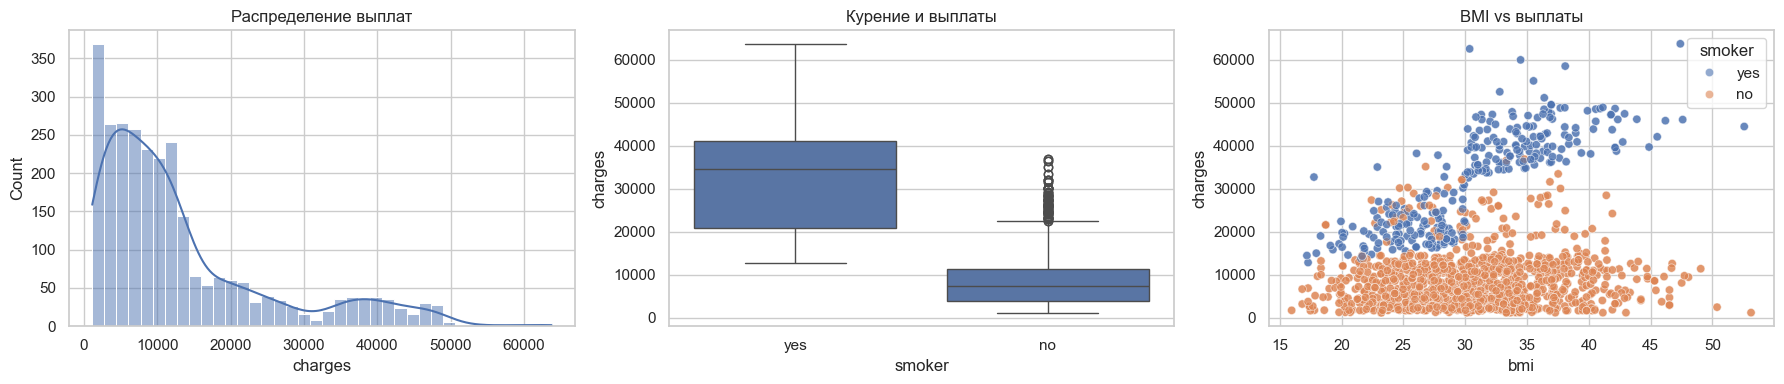

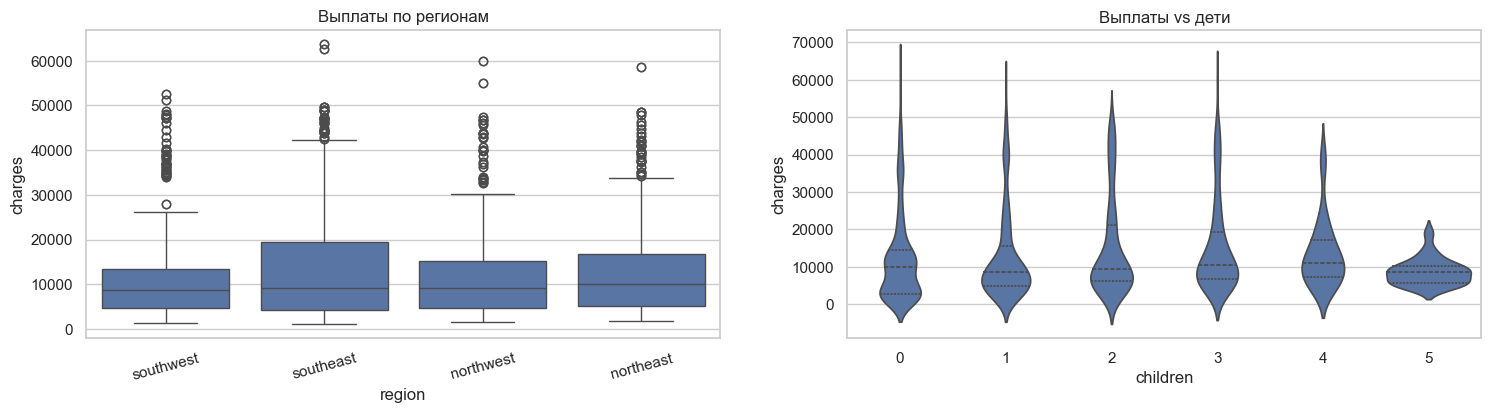

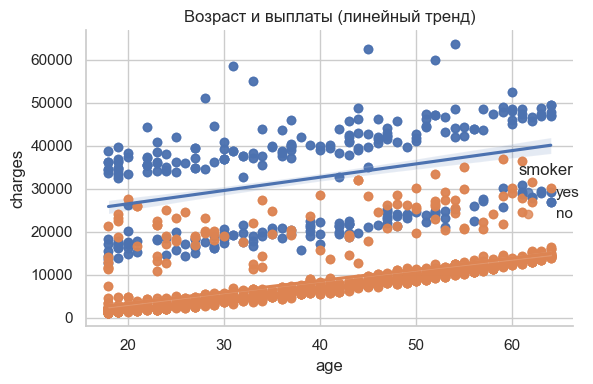

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(reg_target, kde=True, ax=axes[0])
axes[0].set_title("Распределение выплат")

sns.boxplot(data=insurance_df, x="smoker", y="charges", ax=axes[1])
axes[1].set_title("Курение и выплаты")

sns.scatterplot(data=insurance_df, x="bmi", y="charges", hue="smoker", alpha=0.6, ax=axes[2])
axes[2].set_title("BMI vs выплаты")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(18, 4))

sns.boxplot(data=insurance_df, x="region", y="charges", ax=axes[0])
axes[0].set_title("Выплаты по регионам")
axes[0].tick_params(axis="x", rotation=15)

sns.violinplot(data=insurance_df, x="children", y="charges", inner="quart", ax=axes[1])
axes[1].set_title("Выплаты vs дети")

sns.lmplot(data=insurance_df, x="age", y="charges", hue="smoker", height=4, aspect=1.3)
plt.title("Возраст и выплаты (линейный тренд)")
plt.tight_layout()
plt.show()

Бейзлайн линейной регрессии (sklearn)\
Пайплайн с ColumnTransformer и классической линейной моделью

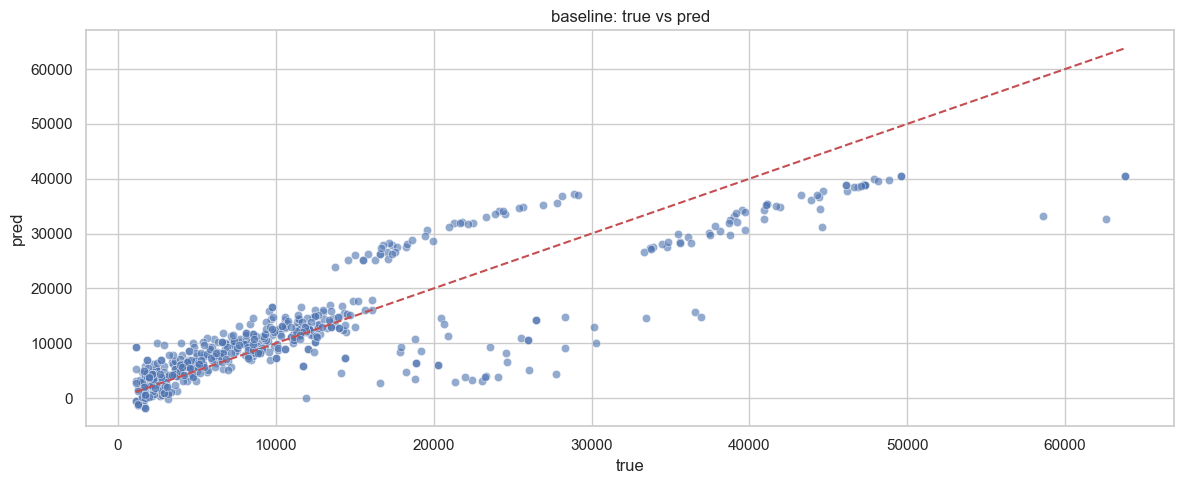

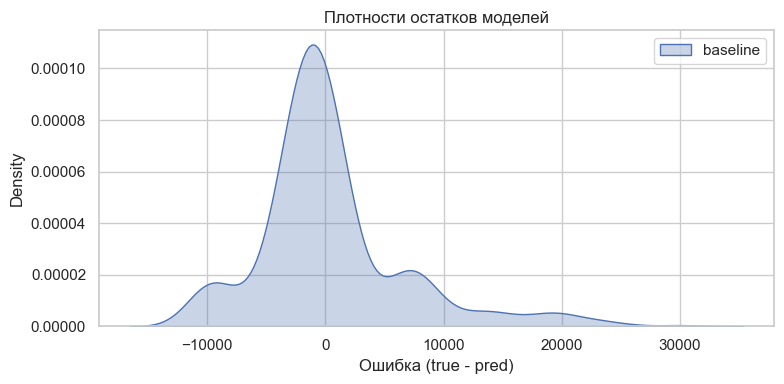

In [12]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    reg_features, reg_target, test_size=0.2, random_state=RANDOM_STATE
)

linreg_baseline = Pipeline(
    steps=[
        ("preprocess", reg_preprocessor),
        ("model", LinearRegression()),
    ]
)

linreg_baseline.fit(X_train_r, y_train_r)
lin_pred = linreg_baseline.predict(X_test_r)

results_reg = {}
results_reg["baseline_linreg"] = regression_report_dict(y_test_r, lin_pred)

plot_predictions(y_test_r, {"baseline": lin_pred})
plot_residuals(y_test_r, {"baseline": lin_pred})

Улучшенная линейная регрессия: Ridge/Lasso тюнинг\
GridSearchCV по типу регуляризации и параметру alpha

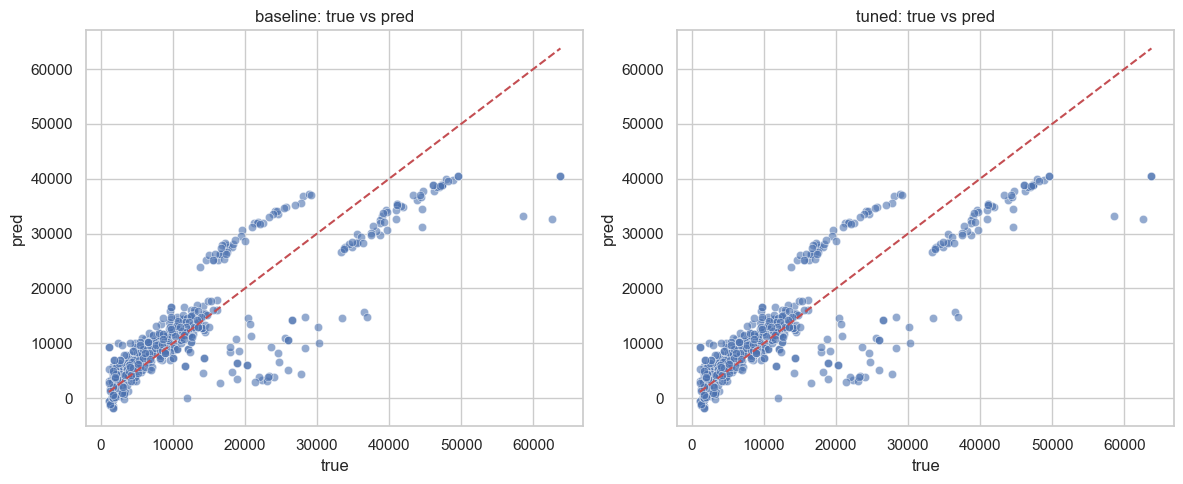

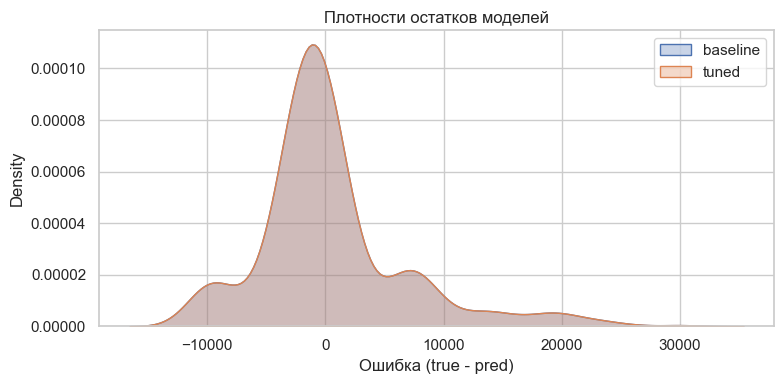

In [13]:
model_grid = [Ridge(), Lasso(max_iter=5000)]
param_grid_reg = {
    "model": model_grid,
    "model__alpha": [0.01, 0.1, 1.0, 10.0],
}

linreg_search = GridSearchCV(
    estimator=Pipeline([("preprocess", reg_preprocessor), ("model", Ridge())]),
    param_grid=param_grid_reg,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1,
)
linreg_search.fit(X_train_r, y_train_r)

best_linreg = linreg_search.best_estimator_
best_lin_pred = best_linreg.predict(X_test_r)

results_reg["tuned_reg"] = regression_report_dict(y_test_r, best_lin_pred)

plot_predictions(y_test_r, {"baseline": lin_pred, "tuned": best_lin_pred})
plot_residuals(y_test_r, {"baseline": lin_pred, "tuned": best_lin_pred})

Важность признаков для лучшей регуляризованной модели\
Вытаскиваем веса и показываем топ-коэффициенты

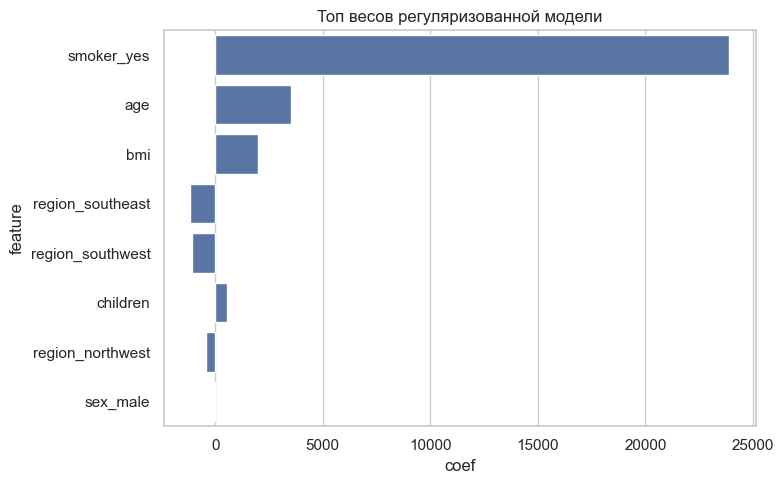

In [14]:
preprocessor = best_linreg.named_steps["preprocess"]
model = best_linreg.named_steps["model"]

feature_names = (
    preprocessor.named_transformers_["num"].get_feature_names_out(num_cols).tolist()
    + preprocessor.named_transformers_["cat"].named_steps["encoder"].get_feature_names_out(cat_cols).tolist()
)

coeffs = pd.DataFrame({"feature": feature_names, "coef": model.coef_})
coeffs_sorted = coeffs.reindex(coeffs.coef.abs().sort_values(ascending=False).index).head(15)
plt.figure(figsize=(8, 5))
sns.barplot(data=coeffs_sorted, x="coef", y="feature")
plt.title("Топ весов регуляризованной модели")
plt.tight_layout()
plt.show()

Ручная линейная регрессия (нормальное уравнение с l2)\
Своя реализация для матричной формулы (ridge)

In [15]:
class CustomLinearRegression:
    def __init__(self, l2=0.0):
        self.l2 = l2

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float)
        ones = np.ones((X.shape[0], 1))
        Xb = np.hstack([ones, X])
        n_features = Xb.shape[1]
        I = np.eye(n_features)
        I[0, 0] = 0  # не регуляризуем свободный член
        self.coef_ = np.linalg.pinv(Xb.T @ Xb + self.l2 * I) @ Xb.T @ y
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        ones = np.ones((X.shape[0], 1))
        Xb = np.hstack([ones, X])
        return Xb @ self.coef_

Оценка кастомной линейной регрессии\
Используем тот же препроцессинг, модель решает нормальное уравнение

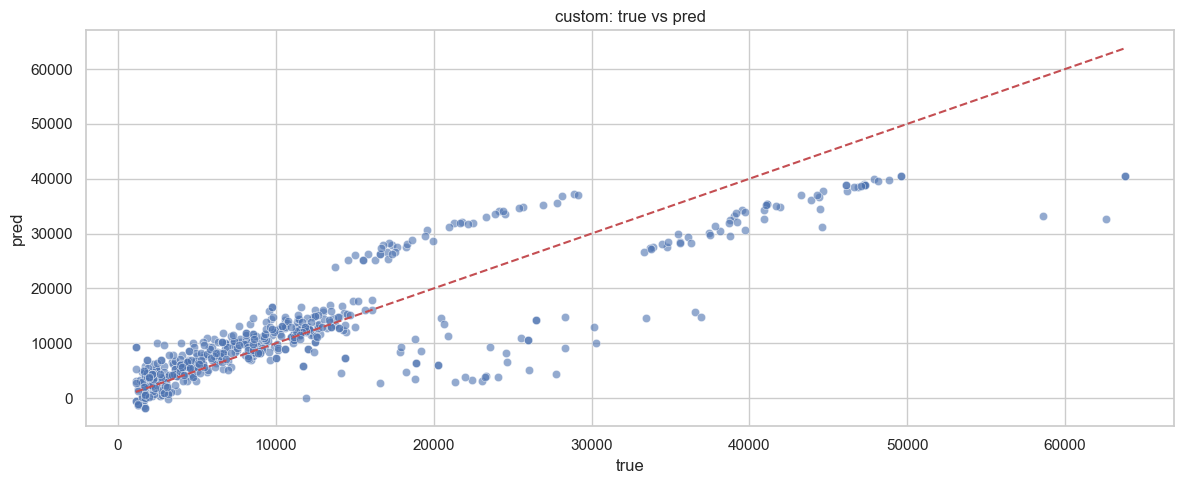

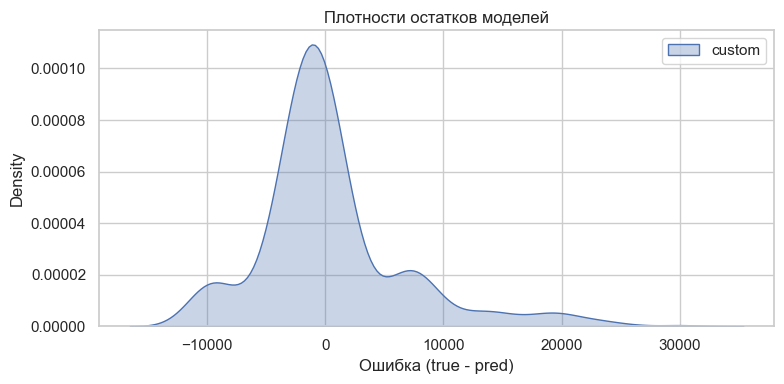


Метрики регрессии (линейные модели)
                       mae       rmse      r2
baseline_linreg  4160.2480  6319.2717  0.7398
tuned_reg        4160.2467  6319.2719  0.7398
custom_linreg    4160.7032  6319.3497  0.7398


In [16]:
custom_linreg = Pipeline(
    steps=[
        ("preprocess", reg_preprocessor),
        ("model", CustomLinearRegression(l2=0.1)),
    ]
)

custom_linreg.fit(X_train_r, y_train_r)
custom_pred = custom_linreg.predict(X_test_r)

results_reg["custom_linreg"] = regression_report_dict(y_test_r, custom_pred)

plot_predictions(y_test_r, {"custom": custom_pred})
plot_residuals(y_test_r, {"custom": custom_pred})

show_results_table(results_reg, "Метрики регрессии (линейные модели)")


## Выводы:
Классификация: логистическая регрессия в базовом и тюнингованном вариантах дает устойчиво высокое AUC (около 0.96) и умеренный F1 (около 0.56). Кастомная реализация увеличила Accuracy и AUC, но снизила полноту и F1, поэтому стандартная логистика остается предпочтительной благодаря стабильности и интерпретируемости коэффициентов.

Регрессия: линейная регрессия и регуляризованные варианты (Ridge, Lasso) показали почти одинаковые результаты (MAE около 4160, R² около 0.74). Это указывает на близкую к линейной структуру данных и отсутствие заметной выгоды от регуляризации. Для повышения качества следует рассматривать нелинейные алгоритмы.
